<a href="https://colab.research.google.com/github/Vigneshthanga/MachineLearning-CMPE257/blob/master/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Applied various Clustering Algorithms on Air Quality Data collected from OpenAQ

##1. Loading the OpenAQ data from Github. Google drive link: https://drive.google.com/drive/folders/1s8OaT46aZ3Cj6BnZN2whouUzPh7_YsST

In [0]:
!git clone https://github.com/Vigneshthanga/MachineLearning-CMPE257
import pandas as pd
import numpy as np
df = pd.read_csv("MachineLearning-CMPE257/AQ_Boston_Cam-Quincy.csv")
df = df.apply(lambda s:s.str.replace('\'', "").str.replace('[', ""))
df.columns = df.columns.str.strip().str.replace('[', '').str.replace(']', '').str.replace('\'','')
df.drop(df.columns[[10,11,12]], axis=1, inplace=True)
df.head(5)

fatal: destination path 'MachineLearning-CMPE257' already exists and is not an empty directory.


,location,city,country,utc,local,parameter,value,unit,latitude,longitude
0,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.035,ppm,43.075371,-70.748017
1,Odiorne State Park,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,o3,0.038,ppm,43.045269,-70.713958
2,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm10,10,µg/m³,43.075371,-70.748017
3,Portsmouth,Boston-Cambridge-Quincy,US,2020-02-09T18:00:00.000Z,2020-02-09T13:00:00-05:00,pm25,4.8,µg/m³,43.075371,-70.748017
4,LYNN,Boston-Cambridge-Quincy,US,2020-02-09T17:00:00.000Z,2020-02-09T12:00:00-05:00,no2,0.008,ppm,42.474701,-70.971901


##2. Change the dtypes of attributes from object to float and encode the location and timestamp.

In [0]:
df['location'] = df['location'].astype('category')
df['location'] = df['location'].cat.codes

df['local'] = df['local'].astype('category')
df['local'] = df['local'].cat.codes

table = pd.pivot_table(df, values='value', index=['location', 'local'], columns=['parameter'], aggfunc=np.sum, fill_value=0)
table.reset_index(inplace=True)
table.columns = table.columns.str.strip()

table['co'] = table['co'].astype(float)
table['no2'] = table['no2'].astype(float)
table['o3'] = table['o3'].astype(float)
table['pm10'] = table['pm10'].astype(float)
table['pm25'] = table['pm25'].astype(float)
table['so2'] = table['so2'].astype(float)
table.head(5)

parameter,location,local,co,no2,o3,pm10,pm25,so2
0,0,0,0.0,0.008,0.0,0.0,0.0,0.0
1,0,1,0.0,0.009,0.0,0.0,0.0,0.0
2,0,2,0.0,0.008,0.0,0.0,0.0,0.0
3,0,3,0.0,0.008,0.0,0.0,0.0,0.0
4,0,4,0.0,0.007,0.0,0.0,0.0,0.0


##3. Indexing the dataframe column with index values.

In [0]:
#co - 2nd column
print(table.iloc[:,3])

0       0.008
1       0.009
2       0.008
3       0.008
4       0.007
        ...  
3862    0.000
3863    0.000
3864    0.000
3865    0.000
3866    0.000
Name: no2, Length: 3867, dtype: float64


##4. Plotting the Elbow curve to identify the K value for K-Means Clustering.

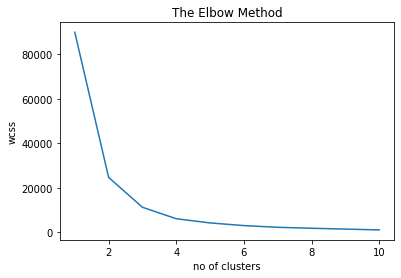

In [0]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
X = table.iloc[:,[3,6]].values
score = []

for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=10)
    kmeans.fit(X)
    score.append(kmeans.inertia_)
plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

##5. Building K-Means cluster using sklearn library.

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
print(y_kmeans)

[1 1 1 ... 0 0 0]


##6. Plotting the K-Means cluster using Matplotlib library.

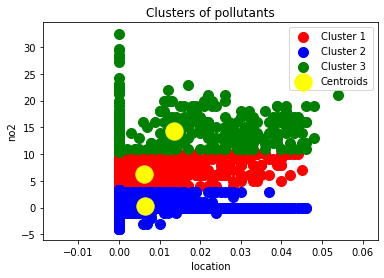

In [0]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
#plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of pollutants')
plt.xlabel('location')
plt.ylabel('no2')
plt.legend()
plt.show()

##7. K-Means Clustering implemented using TensorFlow (Cluster output matches with that of Sklearn)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
centroids [[6.64012185e-03 1.08833768e-01]
 [5.42071494e-03 5.45334555e+00]
 [1.31297071e-02 1.35407950e+01]]


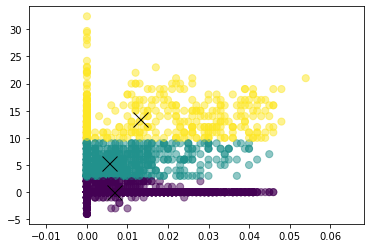

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#points_n = 200
clusters_n = 3
iteration_n = 100

#points = tf.constant(np.random.uniform(0, 10, (points_n, 2)))
points = table.iloc[:,[3,6]].values
centroids = tf.Variable(tf.slice(tf.random_shuffle(points), [0, 0], [clusters_n, -1]))

points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)

distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)

means = []
for c in range(clusters_n):
    means.append(tf.reduce_mean(
      tf.gather(points, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1]))

new_centroids = tf.concat(means, 0)

update_centroids = tf.assign(centroids, new_centroids)
init = tf.global_variables_initializer()

#converting the points from numpy array to tensorflow
data_tf = tf.convert_to_tensor(points, np.float32)

with tf.Session() as sess:
  sess.run(init)
  for step in range(iteration_n):
    [_, centroid_values, points_values, assignment_values] = sess.run([update_centroids, centroids, data_tf, assignments])
    
  print("centroids", centroid_values)

plt.scatter(points_values[:, 0], points_values[:, 1], c=assignment_values, s=50, alpha=0.5)
plt.plot(centroid_values[:, 0], centroid_values[:, 1], 'kx', markersize=15)
plt.show()

##8. Hierachical Clustering using Sklearn library

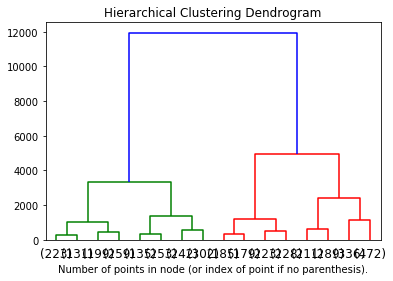

In [0]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(table)

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
